Scanning start dates: 100%|██████████| 8194/8194 [00:01<00:00, 5583.42it/s]



=== SPY First-Passage to -6.2% Drawdown ===
events_count: 3870
   mean_days: 97.53
 median_days: 54.00
    min_days: 1.00
    max_days: 504.00
    p10_days: 10.00
    p25_days: 21.00
    p75_days: 141.00
    p90_days: 254.00

Saved events to: spy_6p2_drawdown_events.csv
Columns: start_date, start_price, target_price, hit_date, hit_price, days_to_hit

=== VaR (loss, +) ===
 horizon_days  confidence  VaR_HS  VaR_Parametric
            1      95.00%   1.81%           1.88%
            1      99.00%   3.24%           2.67%
           10      95.00%   4.83%           5.57%
           10      99.00%   9.36%           7.94%


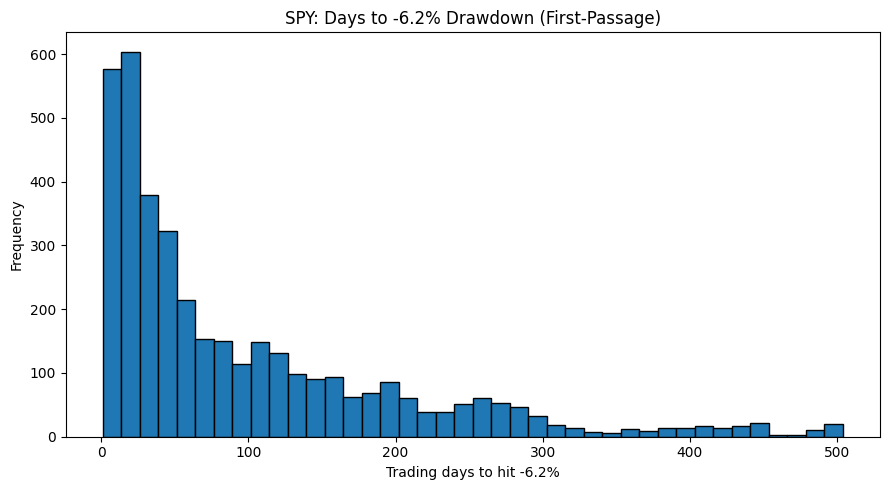

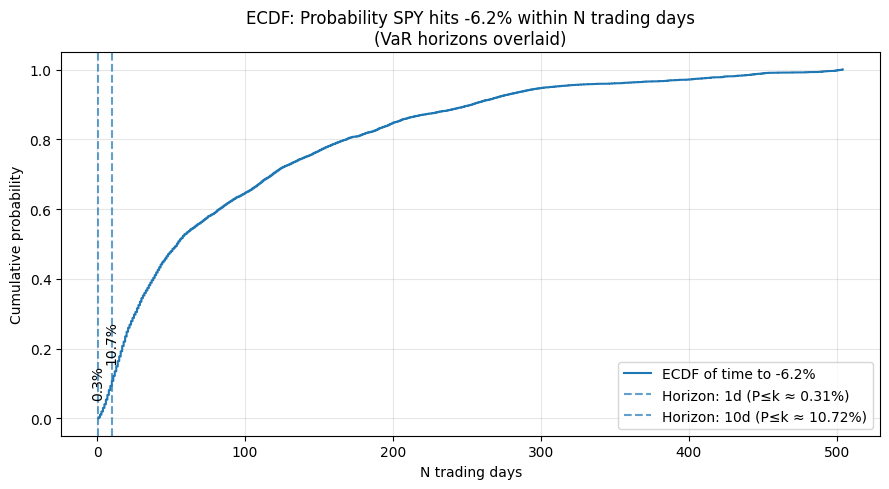

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SPY -6.2% Drawdown First-Passage + VaR Overlay (with tqdm)
----------------------------------------------------------
- Downloads SPY daily data (Adj-like using auto_adjust=True)
- Computes first-passage time to a -6.2% drawdown from each start date
- Prints summary stats, saves all events to CSV
- Plots histogram and ECDF of durations
- Computes 1d and 10d VaR via:
    • Historical Simulation (HS)
    • Parametric (Normal) using daily mean/sigma
- Overlays VaR horizons on the ECDF (vertical lines) and
  annotates probability of hitting -6.2% within those horizons.

Install:
  pip install yfinance pandas numpy matplotlib tqdm
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------- Params --------------------
TICKER = "SPY"
START  = "1993-01-01"
THRESH = 0.062          # 6.2% drop target
MAX_LOOKAHEAD = 252*2   # ~2 years of trading days (cap search for speed)
CSV_OUT = "spy_6p2_drawdown_events.csv"

# VaR settings
CONF_LEVELS = [0.95, 0.99]  # 95%, 99%
HORIZONS    = [1, 10]       # 1-day, 10-day

# z-scores for one-sided (lower-tail) quantiles under Normal
Z_LOWER = {0.95: -1.6448536269514729, 0.99: -2.3263478740408408}

# -------------------- Download --------------------
spy = yf.download(TICKER, start=START, interval="1d", auto_adjust=True, progress=False)

if "Close" not in spy.columns:
    raise RuntimeError("Downloaded data is missing 'Close' column.")

# Ensure we work with a 1-D price series (guard against n×1 dataframes)
prices = spy["Close"].astype(float).dropna().copy()
if isinstance(prices, pd.DataFrame):
    prices = prices.squeeze("columns")

assert prices.ndim == 1, f"Expected 1-D Series for prices, got ndim={prices.ndim}"
dates = prices.index
n = len(prices)
if n < 300:
    raise RuntimeError("Not enough price history downloaded to run the analysis.")

# Daily returns (simple & log)
ret = prices.pct_change().dropna()
logret = np.log1p(ret)

# -------------------- First-passage computation --------------------
durations = []
records = []

for i in tqdm(range(n-1), desc="Scanning start dates"):
    p0 = float(prices.iloc[i])                 # ensure scalar
    target = p0 * (1 - THRESH)

    j_end = min(i + 1 + MAX_LOOKAHEAD, n)
    future = prices.iloc[i+1:j_end]           # 1-D Series
    f_np = future.to_numpy().ravel()          # 1-D numpy array

    hit_idx = np.where(f_np <= target)[0]     # indices relative to future start
    if hit_idx.size > 0:
        j_rel = hit_idx[0] + 1                # +1 because future starts at i+1
        j = i + j_rel
        days = j - i
        durations.append(days)
        records.append({
            "start_date": dates[i].date(),
            "start_price": round(p0, 4),
            "target_price": round(target, 4),
            "hit_date": dates[j].date(),
            "hit_price": round(float(prices.iloc[j]), 4),
            "days_to_hit": int(days)
        })
    # else: no hit within lookahead -> ignore

durations = np.asarray(durations, dtype=float)

# -------------------- Summary stats --------------------
def pct(p):
    return float(np.percentile(durations, p)) if durations.size else np.nan

summary = {
    "events_count": int(durations.size),
    "mean_days": float(np.mean(durations)) if durations.size else np.nan,
    "median_days": float(np.median(durations)) if durations.size else np.nan,
    "min_days": float(np.min(durations)) if durations.size else np.nan,
    "max_days": float(np.max(durations)) if durations.size else np.nan,
    "p10_days": pct(10),
    "p25_days": pct(25),
    "p75_days": pct(75),
    "p90_days": pct(90),
}

print("\n=== SPY First-Passage to -6.2% Drawdown ===")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k:>12}: {v:.2f}")
    else:
        print(f"{k:>12}: {v}")

# -------------------- Save events --------------------
events_df = pd.DataFrame.from_records(records)
events_df.to_csv(CSV_OUT, index=False)
print(f"\nSaved events to: {CSV_OUT}")
if not events_df.empty:
    print("Columns:", ", ".join(events_df.columns))

# -------------------- VaR calculations --------------------
def compounded_kday_returns(r: pd.Series, k: int) -> pd.Series:
    """Compounded k-day simple returns from daily simple returns."""
    return (1 + r).rolling(k).apply(np.prod, raw=True) - 1

def historical_var(r: pd.Series, k: int, conf: float) -> float:
    """Historical Simulation VaR for k-day horizon at confidence conf (positive number for loss)."""
    kret = compounded_kday_returns(r, k).dropna()
    q = np.percentile(kret, (1-conf)*100.0)  # lower-tail quantile (e.g., 5% or 1%)
    return float(-q)

def parametric_var(logr: pd.Series, k: int, conf: float) -> float:
    """Parametric Normal VaR using log-returns; return as simple-return loss (positive)."""
    mu = logr.mean()
    sig = logr.std()
    z = Z_LOWER[conf]  # negative number
    mu_k = mu * k
    sig_k = sig * np.sqrt(k)
    # VaR in log-return space (loss is negative tail)
    vr_log = mu_k + z * sig_k
    # Convert to simple return; VaR is positive loss magnitude
    return float(-(np.expm1(vr_log)))

# Compute and print table
rows = []
for k in HORIZONS:
    for c in CONF_LEVELS:
        var_hs = historical_var(ret, k, c)
        var_par = parametric_var(logret, k, c)
        rows.append({
            "horizon_days": k,
            "confidence": c,
            "VaR_HS": var_hs,
            "VaR_Parametric": var_par
        })

var_df = pd.DataFrame(rows)
print("\n=== VaR (loss, +) ===")
print(var_df.to_string(index=False, float_format=lambda x: f"{100*x:.2f}%"))

# -------------------- Plots --------------------
if durations.size:
    # Histogram
    plt.figure(figsize=(9,5))
    plt.hist(durations, bins=40, edgecolor="black")
    plt.title("SPY: Days to -6.2% Drawdown (First-Passage)")
    plt.xlabel("Trading days to hit -6.2%")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # ECDF
    x = np.sort(durations)
    y = np.arange(1, len(x)+1) / len(x)

    plt.figure(figsize=(9,5))
    plt.plot(x, y, drawstyle="steps-post", label="ECDF of time to -6.2%")

    # Overlay VaR horizons as vertical lines and annotate probability
    for k in HORIZONS:
        # probability drawdown hits within k days = P(T <= k)
        idx = np.searchsorted(x, k, side='right')
        prob = y[idx-1] if idx > 0 else 0.0
        plt.axvline(k, linestyle="--", alpha=0.7, label=f"Horizon: {k}d (P≤k ≈ {prob:.2%})")
        plt.text(k, min(prob+0.05, 0.98), f"{prob:.1%}", rotation=90,
                 va="bottom", ha="center")

    plt.title("ECDF: Probability SPY hits -6.2% within N trading days\n(VaR horizons overlaid)")
    plt.xlabel("N trading days")
    plt.ylabel("Cumulative probability")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No events found within the lookahead window. Consider increasing MAX_LOOKAHEAD or adjusting THRESH.")

# -------------------- Notes --------------------
# • VaR numbers are *loss magnitudes* (positive). E.g., 10d 99% HS VaR = 5% means:
#   with 99% confidence, 10-day losses will not exceed 5% (based on history).
# • ECDF step at horizon k shows the probability the -6.2% drawdown arrives within k days.
# • The overlay visually links a horizon-driven risk metric (VaR) to the time-to-threshold distribution.
